# Get cell cycle label

2023-04-04

In [1]:
# Import Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from anndata import AnnData
from tifffile import imread
from skimage.measure import regionprops

# Customized packages
import starmap.sc_util as su

# test()

## Input

In [2]:
# Set path
# base_path = 'path/to/2022-03-28-TEMPOmap-images'
base_path = 'K:/2022-03-28-TEMPOmap-images/'

out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

## Generate phase_ref label for all conditions

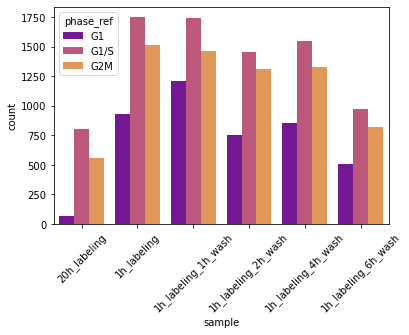

In [3]:
# Set path
# base_path = 'path/to/2022-03-28-TEMPOmap-images'
base_path = 'K:/2022-03-28-TEMPOmap-images/'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

# Load adata
adata = sc.read_h5ad(os.path.join(out_path, '2023-04-05-Rena-EU-starmap-after-pp-300.h5ad'))
adata

# Assign dummy label
adata.obs['phase_ref'] = 'NA'

for current_sample in adata.obs['sample'].unique():
    
    # Remove KD genes 
    cdata = adata[:, 7:]
    cdata = cdata[cdata.obs['sample'] == current_sample, ]

    # Normalization scaling
    sc.pp.normalize_total(cdata)
    sc.pp.log1p(cdata)
    cdata.raw = cdata

    # Scale data to unit variance and zero mean
    sc.pp.scale(cdata)
    
    # Load reference gene list 
    cell_cycle_genes = [x.strip() for x in open(os.path.join(base_path, 'gene_modules/regev_lab_cell_cycle_genes.txt'))]
    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]


    # Get cell cycle genes 
    missed_genes = [x for x in cell_cycle_genes if x not in cdata.var_names]
    cell_cycle_genes = [x for x in cell_cycle_genes if x in cdata.var_names]

    # Compute gene set score
    sc.tl.score_genes_cell_cycle(cdata, s_genes=s_genes, g2m_genes=g2m_genes)

    adata.obs.loc[adata.obs['sample'] == current_sample, 'phase_ref'] = cdata.obs['phase'].values
    
    
adata.obs['phase_ref'] = adata.obs['phase_ref'].replace({'S': 'G1/S'})
adata.obs['phase_ref'] = adata.obs['phase_ref'].astype('category')
adata.obs['phase_ref'] = adata.obs['phase_ref'].cat.reorder_categories(['G1', 'G1/S', 'G2M'])
sns.countplot(x="sample", hue="phase_ref", data=adata.obs, palette='plasma')
plt.xticks(rotation=45)
plt.show()

# output
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
adata.write_h5ad(f"{out_path}/{date}-Rena-EU-starmap-cc.h5ad")